<a href="https://colab.research.google.com/github/yes-G/FussballPrognose/blob/analysis/LeagueAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

The idea is find a football team which has managed to repeat its performance across two consequtive seasons in the past 10 years. Not based on the where they finish in their league, but to see if the points they've scored have been consistant.

In [2]:
!pip install datapackage

     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 72 kB 538 kB/s 
     |████████████████████████████████| 68 kB 6.5 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
     |████████████████████████████████| 242 kB 29.6 MB/s 
     |████████████████████████████████| 131 kB 57.6 MB/s 
     |████████████████████████████████| 126 kB 68.7 MB/s 
     |████████████████████████████████| 8.0 MB 54.6 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 127 kB 60.0 MB/s 
  Created wheel for linear-tsv: filename=linear_tsv-1.1.0-py3-none-any.whl size=7399 sha256=6d49684accb21366c6ea691da1e23b20cf0e999efefd929d61749b6b2a489439
  Stored in directory: /root/.cache/pip/wheels/dd/0a/62/49ee84fab92057fb3e303fb1a59e75ccac6899b417f441305a
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10765 sha256=b1dbd54bb3a08c1b64732569508394f602bc80bf03b37dc16f62a16a451ca476
  Store

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

from scipy.stats import ttest_ind

# How long ago should i look? 
I will examine the data from the past 10 years, for the Spanish 1st Division Football league - the La Liga. Taken literally, one would imagine the creators of the said league to be very arrogant, because its literally means *The League.* And that implies that there can be no other ;)

Is 10 years too much? too less? 

#Datahub

This time instead of scrubbing data from a website, i will use the data from the good folks at datahub.io who make available a large number of datasets. 


In [4]:
import datapackage

data_url = 'https://datahub.io/sports-data/spanish-la-liga/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources

The data for all the seasons is colated into one dataframe.

In [5]:
sources = []
df = None
for resource in resources:
  if resource.tabular:
    #print(resource.name, resource.descriptor['dpp:streamedFrom'])    
    if resource.descriptor['dpp:streamedFrom'] not in sources:
      sources.append(resource.descriptor['dpp:streamedFrom'])
      data = pd.read_csv(resource.descriptor['path'])
      data['Season']=resource.name
      if df is None:
        df = data.copy()
      else:
        df = pd.concat([df, data])
#print(sources)
#The season name is derived from the name of the csv file, but that is not very 
#"user" friendly - looks like season-0910_csv, hence a little clean up is done
#with the code below.
df.Season = df.Season.apply(lambda x: '20'+str.join('-20', #Step2: Add the 2000's qualifier and a - between the two years
                                      re.findall('..',  #Step 1: split the string with every 2 digits.
                                     re.sub('[a-z]+|[-_]', '',x))#Step 0. ignore season, csv and the - and _ 
                            ))

#How many teams appear in the dataset and in how many seasons did a team appear in?

From the seasons from 2008-09 upto 2018-19, a total of 35 teams have made an appearance in the *La Liga*. Only 20 teams participate in a season. 

In [6]:
Teams = df.HomeTeam.unique().tolist()
Teams.sort()
dfSeason = pd.DataFrame(df.groupby(by='HomeTeam')['Season'].nunique()).reset_index()


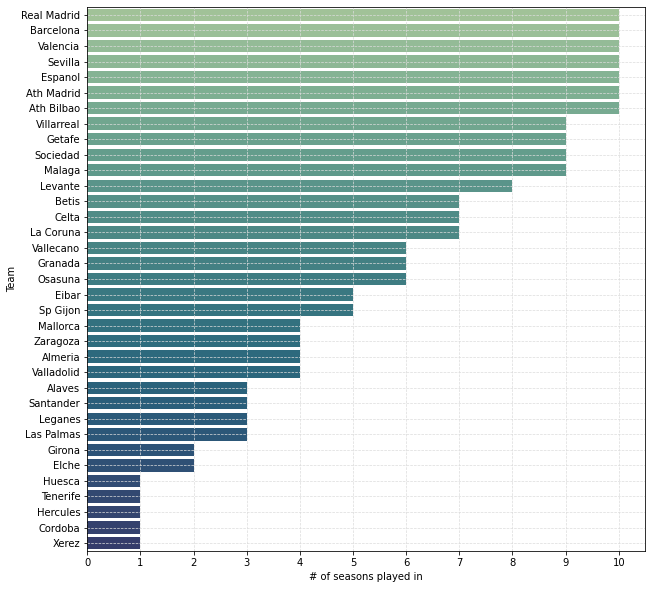

In [7]:
plt.figure(figsize=(10,10));
sns.barplot(x='Season', 
            y='HomeTeam',
            palette='crest',
            data=dfSeason.sort_values(by='Season', ascending=False));
x = np.arange(0, 11)
plt.ylabel('Team');
plt.xlabel('# of seasons played in');
plt.grid(color='gainsboro', linestyle='--', linewidth=0.7);
plt.xticks(ticks=x);

As shown in the following figure, seven teams have made an appearance in every season - *Real Madrid, Barcelona, Valencia, Sevilla, Español, Athletico Mardric*, and *Athletico Bilbao*. 

Five teams - *Huesca*, *Tenerife*, *Hercules*, *Cordoba* and *Xerez* - have made an appearance only once. Since, the question i want to answer is that of consistancy, these 5 one-hit wonders will be in the focus during the analysis. 

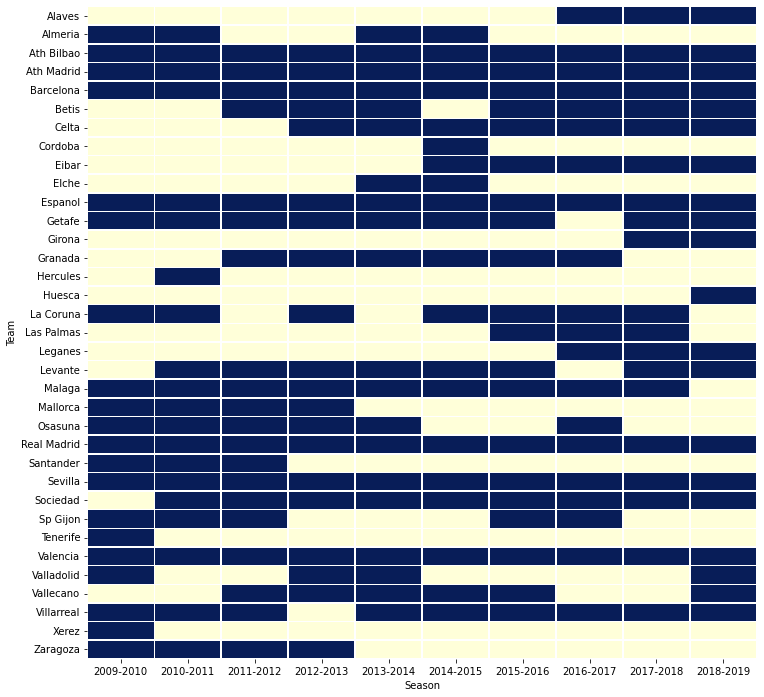

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(pd.crosstab(df.HomeTeam, df.Season), linewidths=.5, cmap="YlGnBu", cbar=False);
plt.ylabel('Team');

In [50]:
cols = ['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']
df2 = df[cols].copy()
df2[['SH', 'SA']] = df2.apply(lambda x: [3, 0] if x['FTHG'] > x['FTAG'] else [1, 1] if x['FTHG'] == x['FTAG'] else [0,3], axis=1, result_type='expand')
df2.Date=df2.Date.astype(np.datetime64)

In [64]:
def PointsEverySeason(data, team):
  """compute point for the team in all the """
  points = None
  for season in data.Season.unique():
    sH = data[(data.Season == season) & (data.HomeTeam==team)].copy()
    sH['Points']=sH.SH
    sA = data[(data.Season == season) & (data.AwayTeam==team)].copy()
    sA['Points']=sA.SA
    s = pd.merge(sH, sA, how='outer').sort_values(by='Date', ascending=True).reset_index(drop=True).reset_index()
    #s.Points = s.Points.cumsum()
    s['MatchDay']=s['index']+1
    s.drop(['index'], axis=1, inplace=True)
    if points is None:
      points = s.copy()
    else:
      points = points.append(s, ignore_index=True)
  return points

#display(points.head())
#display(points.shape)

In [65]:
#Compute back-to-back seasons
def IdentifyBackToBackSeasons(data, team):
  seasons = data[data.HomeTeam==team].Season.unique();
  backToBack = []
  for i, val in enumerate(seasons[:-1]):
    s1 = str.split(seasons[i],'-')
    s2 = str.split(seasons[i+1], '-')
    if s1[0]==s2[1]:
      #print(i, val, seasons[i], seasons[i+1])
      backToBack.insert(0,  [seasons[i], seasons[i+1]])
  return backToBack

In [76]:
teams = df2.HomeTeam.unique()
teams.sort()
similarStories = []
for team in teams:
  points = PointsEverySeason(df2, team)
  backToBack = IdentifyBackToBackSeasons(df2, team)
  for i, v in enumerate(backToBack,1):
    p1 = points[points.Season==v[0]].copy().reset_index(drop=True)
    p2 = points[points.Season==v[1]].copy().reset_index(drop=True)

    p1['PointsC'] = p1.Points.cumsum()
    p2['PointsC'] = p2.Points.cumsum()

    s, p = ttest_ind(p2.Points, p1.Points)
    if p > 0.90:
      pairPoints = pd.concat([p1, p2],ignore_index=True)
      similarStories.insert(0, {'Team':team,'seasons':v,'p-value':p, 'data':pairPoints})


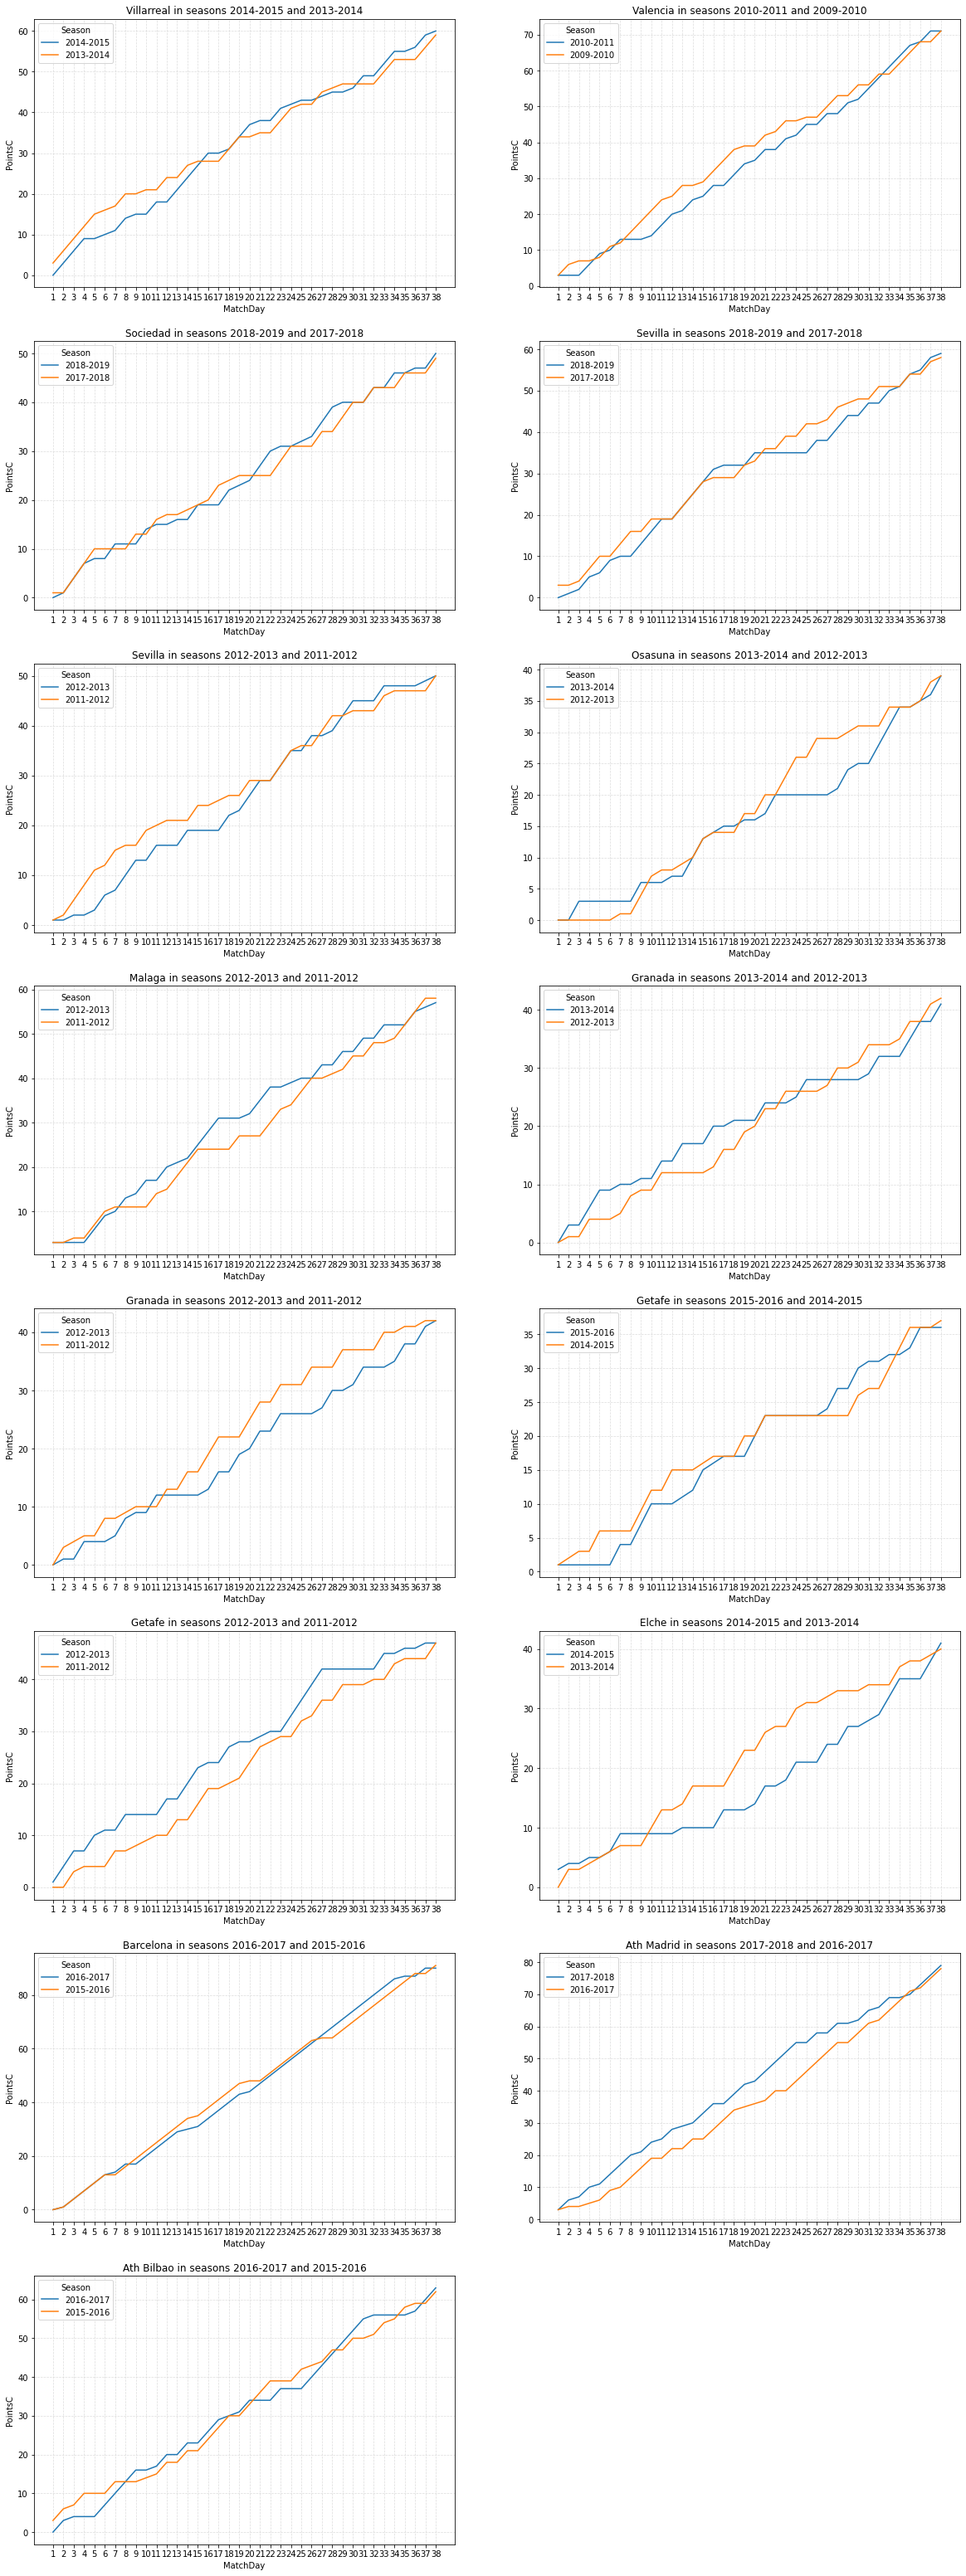

In [79]:

N = len(similarStories)
R = int(N/2)+1
plt.figure(figsize=(20,R*7));
x = np.arange(1,39)
for i,story in enumerate(similarStories,1):
  plt.subplot(R,2,i)
  sns.lineplot(y=story['data'].PointsC, x=story['data'].MatchDay, hue=story['data'].Season);
  plt.grid(color='gainsboro', linestyle='--', linewidth=0.7);
  plt.xticks(ticks=x);
  plt.title(f'{story["Team"]} in seasons {story["seasons"][0]} and {story["seasons"][1]}')